<h2><center>Dataset Description</center></h2>

Feature | Description 
----------|---------------
**`local_time`** | Date and time(in milliseconds) of the bitcoin market. <br> **Examples:** '2021-02-14 00:24:41.875447-08:00' 
**`ask`**    | The lowest price a seller will accept for the corresponding share of the bitcoin
**`bid`** |The highest price a buyer will pay for the corresponding share of the bitcoin<br> **Examples:** '3213'
**`mid_price`** |  The average of the ask and bid prices (Predictor variable)<br> **Example:** 8916.855

<h2>Importing Libraries</h2>

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

from keras.models import model_from_json

from tqdm.notebook import tqdm 

<h2> 1. Loading and Understanding the data </h2>

In [91]:
df=pd.read_csv('./data/btc_usd_pricing_data.csv')
df.drop('Unnamed: 0',axis=1, inplace=True)
df.head()

,ask,bid,local_time,mid_price
0,48916.86,48916.85,2021-02-14 00:24:41.875447-08:00,48916.855
1,48916.86,48916.85,2021-02-14 00:24:41.898807-08:00,48916.855
2,48916.86,48916.85,2021-02-14 00:24:41.927107-08:00,48916.855
3,48916.86,48916.85,2021-02-14 00:24:41.948069-08:00,48916.855
4,48916.86,48916.85,2021-02-14 00:24:41.973221-08:00,48916.855


In [3]:
df.tail()

,ask,bid,local_time,mid_price
8659566,50482.26,50482.25,2021-02-24 23:59:59.409873-08:00,50482.255
8659567,50482.26,50482.25,2021-02-24 23:59:59.539362-08:00,50482.255
8659568,50482.26,50482.25,2021-02-24 23:59:59.680420-08:00,50482.255
8659569,50482.26,50482.25,2021-02-24 23:59:59.794040-08:00,50482.255
8659570,50482.26,50482.25,2021-02-24 23:59:59.916656-08:00,50482.255


In [4]:
df.shape

(8659571, 4)

In [5]:
print('From:',df['local_time'].min(),' To',df['local_time'].max())

From: 2021-02-14 00:24:41.875447-08:00  To 2021-02-24 23:59:59.916656-08:00


As we can see there is data for more than 86 lakh rows of bitcoin prices from the start of 14th February till the end of 24th of February. We should also note that bitcoin has 24-hour markets.

### Convert local_time to into date_time data type 

In [92]:
df = df.reset_index(drop=True)
#df['local_time']=df['local_time'].map(lambda x: str(x)[:-4]) #remove last 4 characters in time
df['datetime'] = pd.to_datetime(df['local_time'],format='%Y-%m-%d %H:%M:%S.%f')
df.head(2)

,ask,bid,local_time,mid_price,datetime
0,48916.86,48916.85,2021-02-14 00:24:41.875447-08:00,48916.855,2021-02-14 00:24:41.875447-08:00
1,48916.86,48916.85,2021-02-14 00:24:41.898807-08:00,48916.855,2021-02-14 00:24:41.898807-08:00


In [93]:
df.drop('local_time',axis=1, inplace=True)

<h2>2. Exploratory Data Analysis </h2>

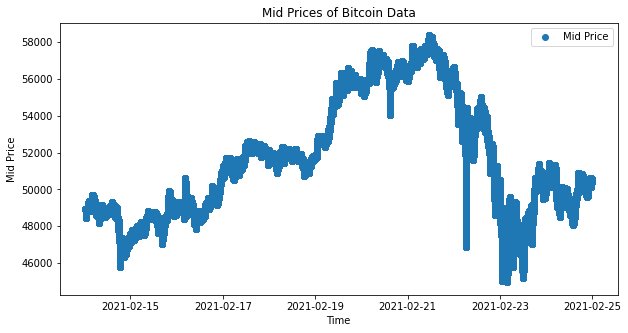

In [89]:
plt.figure(figsize=(10, 5))
plt.plot_date(df['datetime'],df['mid_price'],label='Mid Price')
plt.title('Mid Prices of Bitcoin Data')
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(loc='best')
plt.show()

### Bitcoin Market Fluctuations in a day (24/02/2020)

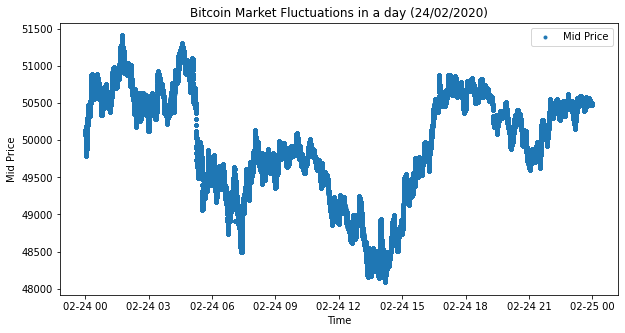

In [95]:
start_date = '2021-02-24 00:00:00'
end_date = '2021-02-24 23:59:59.916656-08:00'
df_day=df[df['datetime'].between(start_date, end_date)]
#df_day.loc[:,'datetime'] = df_day.loc[:,'datetime'].dt.strftime('%H:%M:%S.%f')
plt.figure(figsize=(10, 5))
plt.plot_date(df_day['datetime'],df_day['mid_price'],label='Mid Price',fmt ='.')
plt.title('Bitcoin Market Fluctuations in a day (24/02/2020)')
plt.xlabel('Time')
plt.ylabel('Mid Price')
plt.legend(loc='best')
plt.show()

### Bitcoin Market Fluctuations in a week

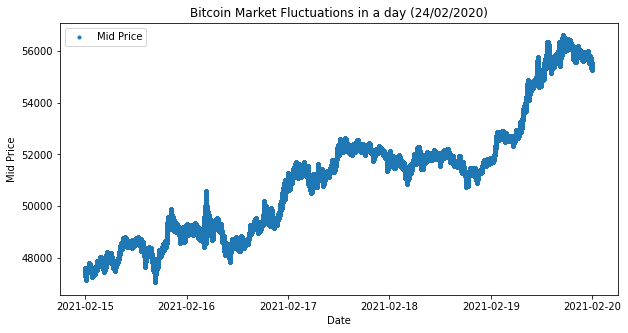

In [90]:
start_date = '2021-02-15 00:00:00'
end_date = '2021-02-19 23:59:59.916656-08:00'
df_day=df[df['datetime'].between(start_date, end_date)]
plt.figure(figsize=(10, 5))
plt.plot_date(df_day['datetime'],df_day['mid_price'],label='Mid Price',fmt = '.')
plt.legend(loc='best')
plt.title('Bitcoin Market Fluctuations in a day (24/02/2020)')
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.show()

### Check Interval sizes

In [123]:
t=[]
for i in tqdm(range(df.shape[0]-1)):
    tdelta = df.loc[i+1,'datetime'] - df.loc[i,'datetime']
    t.append(tdelta.total_seconds())

  0%|          | 0/8659570 [00:00<?, ?it/s]

Mean of the difference between two timestamps: 0.10958027260118003
Standard Deviation of the difference between two timestamps: 0.1672088751606061


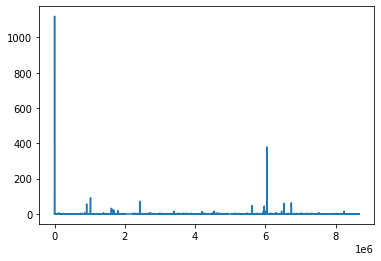

In [144]:
interval_diff = np.array(t)
print('Mean of the difference between two timestamps:',interval_diff.mean())
print('Standard Deviation of the difference between two timestamps:',interval_diff.var())
plt.plot(interval_diff)
plt.show()

The interval sizes has a mean of 0.109 but has an high variance which means there isn't a fixed time interval in the data. From th plot above, we can note that mostly all the datapoints has an interval close to zero but there are also around 400 intervals at 6 seconds.

In [151]:
print('There is difference of',np.round(interval_diff.max()/60,2), 'minutes between the timestamp at index'
      ,interval_diff.argmax(),'and',interval_diff.argmax()+1)
df[881:884]

There is difference of 18.67 minutes between the timestamp at index 882 and 883


,ask,bid,local_time,mid_price,datetime
881,48916.96,48916.95,2021-02-14 00:25:03.755801-08:00,48916.955,2021-02-14 00:25:03.755801-08:00
882,48916.96,48916.95,2021-02-14 00:25:03.780956-08:00,48916.955,2021-02-14 00:25:03.780956-08:00
883,48670.08,48670.07,2021-02-14 00:43:44.221668-08:00,48670.075,2021-02-14 00:43:44.221668-08:00


Therefore, the data has to be split into some fixed interval which can be set as tiwce the mean.

## 3. Data Pre-Processing

In [8]:
df=df.resample('200ms', on='datetime').agg({'mid_price':'mean', 'bid':'mean','ask':'mean'})
df.head(4)

,mid_price,bid,ask
datetime,,,
2021-02-14 00:24:41.800000-08:00,48916.855,48916.85,48916.86
2021-02-14 00:24:42-08:00,48916.855,48916.85,48916.86
2021-02-14 00:24:42.200000-08:00,48916.855,48916.85,48916.86
2021-02-14 00:24:42.400000-08:00,48916.855,48916.85,48916.86


The data is split into time intervals of 200 milliseconds and the average of the prices are taken

In [9]:
df[df['mid_price'].isna()]

,mid_price,bid,ask
datetime,,,
2021-02-14 00:25:03.800000-08:00,NaN,NaN,NaN
2021-02-14 00:25:04-08:00,NaN,NaN,NaN
2021-02-14 00:25:04.200000-08:00,NaN,NaN,NaN
2021-02-14 00:25:04.400000-08:00,NaN,NaN,NaN
2021-02-14 00:25:04.600000-08:00,NaN,NaN,NaN
...,...,...,...
2021-02-24 23:27:10.200000-08:00,NaN,NaN,NaN
2021-02-24 23:30:01.200000-08:00,NaN,NaN,NaN
2021-02-24 23:35:50.200000-08:00,NaN,NaN,NaN


The above table shows that there is no prices data available in some of the equally splitted time interval(200ms). These missing value has to be imputed using some technique.

In [10]:
df.drop(['ask','bid'],axis=1, inplace=True)

The ask prices and bid prices are dropped since it can't be included in the predictions of the mid prices as the mid prices are simply the average of the ask and bid prices

An example of the method I have used to compute the missing values of prices is given below.

In [11]:
a=[10,10,10,np.nan,np.nan,np.nan,15,15,15,20,np.nan,25]
for i in range(len(a)):
    if np.isnan([a[i]]):
        for j in range(i+1,len(a)):
            if np.isnan(a[j]) == False:
                break
        a[i:j]=np.linspace(a[i-1],a[j],j-i+2)[1:-1]        
print(a)

[10, 10, 10, 11.25, 12.5, 13.75, 15, 15, 15, 20, 22.5, 25]


Filling the missing value with mean/mode of the prices would be irrelevant for bitcin prices. Instead of filling the previous bitcoin price in the data, I have computed a set of values for the steady increase/decrease of the stock prices for the time period of missing prices. This ensures that there won't be a sudden fluctuation even when the data is missing for a few minutes. 

In [12]:
df[df['mid_price'].isna()]
mid_price=list(df['mid_price'])
for i in range(len(mid_price)):
    if np.isnan([mid_price[i]]):
        for j in range(i+1,len(mid_price)):
            if np.isnan(mid_price[j]) == False:
                break
        mid_price[i:j]=np.linspace(mid_price[i-1],mid_price[j],j-i+2)[1:-1]
df.loc[:,'mid_price']=mid_price
df[df['mid_price'].isna()]

,mid_price
datetime,


All the missing values are imputed using the above method

### we require only the mid price value, so we subset that and convert it to numpy array

In [13]:
df = df[['mid_price']]
dataset = df.values
dataset = dataset.astype('float32')
dataset

array([[48916.855],
       [48916.855],
       [48916.855],
       ...,
       [50482.254],
       [50482.254],
       [50482.254]], dtype=float32)

Usually column standardization wont be neccessary if the columns is of the same scale. But neural networks are sensitive to input data, especiallly when we are using activation functions like sigmoid or tanh activation functions are used. So we rescale our data to the range of 0-to-1, using StandardScaler

In [14]:
scaler = StandardScaler()
dataset = scaler.fit_transform(dataset)

The bitcoin prices can shoot above the given maximum or minimum price in the dataset. Hence we will use StandardScalar instead of Min-Max Scalar for standardization 

In [15]:
dataset

array([[-0.8725896],
       [-0.8725896],
       [-0.8725896],
       ...,
       [-0.3852171],
       [-0.3852171],
       [-0.3852171]], dtype=float32)

## Train-Test Split: Time Based Splitting

In [16]:
train_size = int(len(dataset) * 0.70)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
print(len(train), len(test))

3321213 1423378


The function called create_dataset, which take two inputs, 

1. Dataset - numpy array that we want to convert into a dataset
2. look_back - number of previous time steps to use as input variables to predict the next time period


In [17]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [24]:
look_back = 10
trainX, trainY = create_dataset(train, look_back=look_back)
testX, testY = create_dataset(test, look_back=look_back)

In [25]:
trainX

array([[-0.8725896, -0.8725896, -0.8725896, ..., -0.8725896, -0.8725896,
        -0.8725896],
       [-0.8725896, -0.8725896, -0.8725896, ..., -0.8725896, -0.8725896,
        -0.8725896],
       [-0.8725896, -0.8725896, -0.8725896, ..., -0.8725896, -0.8725896,
        -0.8725896],
       ...,
       [ 1.4950176,  1.4950176,  1.4955127, ...,  1.4955127,  1.4955127,
         1.4955127],
       [ 1.4950176,  1.4955127,  1.4955127, ...,  1.4955127,  1.4955127,
         1.4955127],
       [ 1.4955127,  1.4955127,  1.4955127, ...,  1.4955127,  1.4955127,
         1.4955127]], dtype=float32)

In [26]:
trainY

array([-0.8725896, -0.8725896, -0.8725896, ...,  1.4955127,  1.4955127,
        1.50055  ], dtype=float32)

In [27]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

## 4. Model Building & Evaluation

## Stacked LSTM model

In [30]:
model = Sequential()
model.add(LSTM(10,return_sequences=True, input_shape=(1, look_back)))
model.add(LSTM(10))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [39]:
file = open('model.json', 'r')
loaded  = file.read()
file.close()

model = model_from_json(loaded)
model.load_weights('lstm_best_bit_coin_prediction.h5')
model.compile(loss='mean_squared_error', optimizer='adam')

In [31]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 1, 10)             840       
_________________________________________________________________
lstm_3 (LSTM)                (None, 10)                840       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 1,691
Trainable params: 1,691
Non-trainable params: 0
_________________________________________________________________


In [32]:
model.fit(trainX, trainY, validation_data=(testX,testY), epochs=100, batch_size=256, verbose=1)

Epoch 1/100
12974/12974 [==============================] - 30s 2ms/step - loss: 0.0076 - val_loss: 3.4339e-05
Epoch 2/100
12974/12974 [==============================] - 27s 2ms/step - loss: 6.4244e-06 - val_loss: 2.2549e-05
Epoch 3/100
12974/12974 [==============================] - 26s 2ms/step - loss: 5.0979e-06 - val_loss: 1.7411e-05
Epoch 4/100
12974/12974 [==============================] - 25s 2ms/step - loss: 4.3081e-06 - val_loss: 1.1967e-05
Epoch 5/100
12974/12974 [==============================] - 26s 2ms/step - loss: 3.7734e-06 - val_loss: 1.0743e-05
Epoch 6/100
12974/12974 [==============================] - 26s 2ms/step - loss: 3.3611e-06 - val_loss: 8.5712e-06
Epoch 7/100
12974/12974 [==============================] - 29s 2ms/step - loss: 3.2512e-06 - val_loss: 7.1559e-06
Epoch 8/100
12974/12974 [==============================] - 26s 2ms/step - loss: 2.9442e-06 - val_loss: 9.5928e-06
Epoch 9/100
12974/12974 [==============================] - 25s 2ms/step - loss: 2.8041e-06 -

## Save Model architecture and weights

In [36]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("lstm_best_bit_coin_prediction.h5")
print("Saved model to disk")

Saved model to disk


## Predicting Bitcoin prices

In [33]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

We have to invert the predictions before calculating error to so that reports will be in same units as our original data

In [34]:
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [35]:
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:, 0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:, 0]))
print('Test Score: %.2f RMSE' % (testScore))


Train Score: 2.62 RMSE
Test Score: 6.62 RMSE


The hyperparameters such as epoch,optimizers and batch_sizes were tuned to get the best model with the least root mean square error

# 5. Plotting Results

## Plotting Predicted Bitcoin Prices

In [40]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict) + look_back, :] = trainPredict
 

In [41]:
 # shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict) + (look_back * 2) + 1:len(dataset) - 1, :] = testPredict

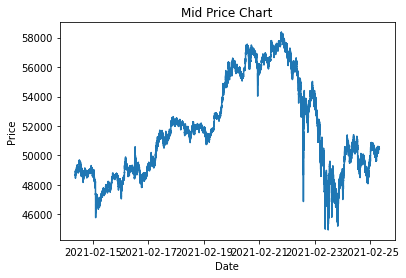

In [42]:
plt.plot(df['mid_price'], label='Actual')
plt.title('Mid Price Chart')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

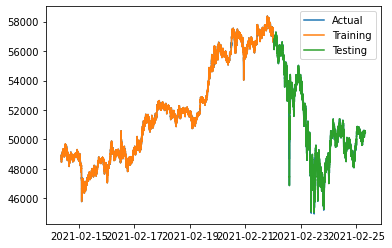

In [43]:
plt.plot(df['mid_price'], label='Actual')
plt.plot(pd.DataFrame(trainPredictPlot, columns=["close"], index=df.index).close, label='Training')
plt.plot(pd.DataFrame(testPredictPlot, columns=["close"], index=df.index).close, label='Testing')
plt.legend(loc='best')

plt.show()

The predicted prices are appended to the orginal dataset

In [45]:
pred_price=np.empty_like(dataset.reshape(len(dataset)))
pred_price[look_back:len(trainPredict) + look_back]=trainPredict.reshape(len(trainPredict))
pred_price[len(trainPredict) + (look_back * 2) + 1:len(dataset) - 1]=testPredict.reshape(len(testPredict))
print(len(pred_price))
df.loc[:,'pred_price']=pred_price
df=df[look_back:-1] #first 10 rows are skipped since it is used to compute future prices

4744591


## Predicting directionality of the mid-price movement using predicted prices

In [71]:
price=df['pred_price']
price_movement=[np.nan for i in range(len(price))]
for i in range(len(price)):
    if price[i]>price[i-1]:
        price_movement[i]='Upward'
    elif price[i]<price[i-1]:
        price_movement[i]='Downward'
df['price_movement'] = price_movement #The rows where there is a change in price are populated
df['price_movement'] = df['price_movement'].fillna(method='bfill').fillna(method='ffill') #The rest of the rows are populated using the following price movement
df[70:80]

,mid_price,pred_price,price_movement
datetime,,,
2021-02-14 00:24:55.800000-08:00,48916.905000,48916.328125,Downward
2021-02-14 00:24:56-08:00,48916.750714,48916.328125,Downward
2021-02-14 00:24:56.200000-08:00,48916.725000,48916.195312,Downward
2021-02-14 00:24:56.400000-08:00,48916.725000,48916.152344,Downward
2021-02-14 00:24:56.600000-08:00,48916.725000,48916.148438,Downward
2021-02-14 00:24:56.800000-08:00,48916.725000,48916.144531,Downward
2021-02-14 00:24:57-08:00,48916.725000,48916.156250,Upward
2021-02-14 00:24:57.200000-08:00,48916.725000,48916.148438,Downward
2021-02-14 00:24:57.400000-08:00,48916.725000,48916.152344,Upward


### Running Script File

In [90]:
%run -i predict.py

Test Score: 4.24 RMSE


C:\Users\Gopinath\Ipython notebooks\InsAIt Data\predict.py:102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['price_movement'] = price_movement  # The rows where there is a change in price are populated
C:\Users\Gopinath\Ipython notebooks\InsAIt Data\predict.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['price_movement'] = df['price_movement'].fillna(method='bfill').fillna(


Saved final csv file with predicted prices and price movement
